In [1]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm 

from statannotations.Annotator import Annotator

import matplotlib.pyplot as plt
import seaborn as sns
import numba as nbj
from aicsimageio import AICSImage

path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant/'
sys.path.append(path_to_quant)

from confocalQuant.segmentation import load_3D, impose_segmentations, int_to_float, run_med_filter, bgrnd_subtract, get_anisotropy, do_inference, sigmoid, gamma_correct_image, get_czi_files, extract_channels, impose_segmentation, float_to_int, hide_masks, impose_segmentation_all
from confocalQuant.stats import load_im, compute_per_cell_stats, get_expectations, compute_nested_anova
from confocalQuant.qc import return_channel_moments_per_im, get_day_and_time, get_metadata
from confocalQuant.plotting import plot_hist, plot_treatments, plot_lines, plot_scatter, plot_boxplot_by_treatment
from confocalQuant.image import save_mean_proj, add_inset, plot_axis, get_rep_im, add_scale_bar, get_mean_projections
from confocalQuant.data_handling import load_im_from_memmap, get_id_data, get_meta_vectors, print_readme, print_failed_jobs, return_results,get_out_files,is_string_present, return_non_unique_indices, print_metadata, compute_avs, extract_sbatch_parameters
from confocalQuant.widgets import toggle_filters, ImageBrowser

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


##### 0. Sanity checks

In [38]:
out_parent = '../new_outs/iNbatch01172024_CTP1b_Lipidspot_out/'
in_parent = '../new_data/iNbatch01172024_CTP1b_Lipidspot/'
files = get_czi_files(in_parent)

In [35]:
dictionaries = [get_metadata(in_parent+x) for x in files]
df = pd.DataFrame(dictionaries)
print('The following metadata variables are NOT consistent across images:')
temp = return_non_unique_indices(df)

The following metadata variables are NOT consistent across images:
SizeZ
AcquisitionDateAndTime
LaserEnableTime


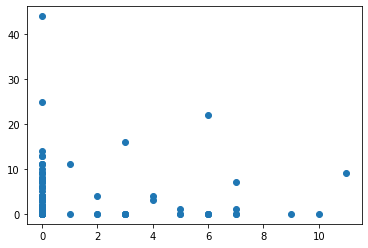

In [40]:
img = AICSImage(in_parent + files[np.random.randint(0,len(files), 1)[0]])
index = np.random.randint(0,len(img.data[0][0].ravel()),1000)
plt.scatter(img.data[0][0].ravel()[index], img.data[0][1].ravel()[index])

In [41]:
img.channel_names

['AF647-T1', 'AF555-T2', 'AF488-T3', 'H3258-T4']

In [42]:
img.physical_pixel_sizes

PhysicalPixelSizes(Z=1.0, Y=0.311962890625, X=0.311962890625)

##### 0.1. Any failed jobs?

In [43]:
print_failed_jobs(out_parent)

slurm-25545584_5.out
slurm-25545584_7.out


##### 0.1. Toggle Segmentations and toss any bad images

In [27]:
I = ImageBrowser('../new_outs/iNbatch01172024_CTP1b_Lipidspot_out/segmentations/')

Output()

In [33]:
I.discard

['2707496179.png',
 '6403269957.png',
 '8901905755.png',
 '4270327797.png',
 '1554800608.png',
 '9386715462.png',
 '4536609971.png',
 '3882591512.png',
 '2831733811.png',
 '2804481119.png']

In [ ]:
# toggl images pre projection
segs = impose_segmentations(zi_per_job, Nzi_per_job, all_mat, all_masks, val=.2, files=[2,3])
toggle_filters(files[0], in_parent, [2,0,1], segs) 

##### 1. Load the data

In [59]:
lines, treat = get_meta_vectors(in_parent, files, '_')
all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID_per_job = return_results(out_parent+'out.sbatch', '.')

In [100]:
# toss the images from above
discard = set([x.split('.')[0] for x in I.discard])
keep_indices = np.argwhere([str(x) not in discard for x in randID_per_job.reshape(-1)]).reshape(-1)

In [94]:
m, f = load_im_from_memmap(48, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)

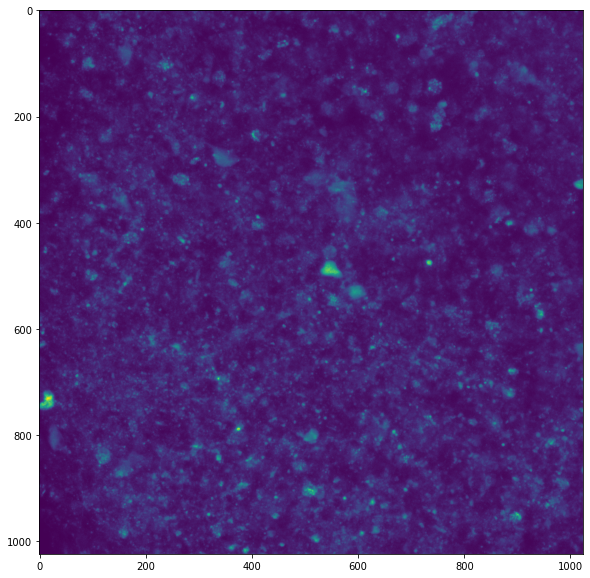

In [99]:
plt.figure(figsize=(10,10))
plt.imshow(np.mean(f[:,:,:,1], axis=0))

##### 2. Compute stats

In [214]:
# determine which threshold to use
m, f = load_im_from_memmap(keep_indices[20], zi_per_job, Nzi_per_job, probs, all_masks, all_mat)

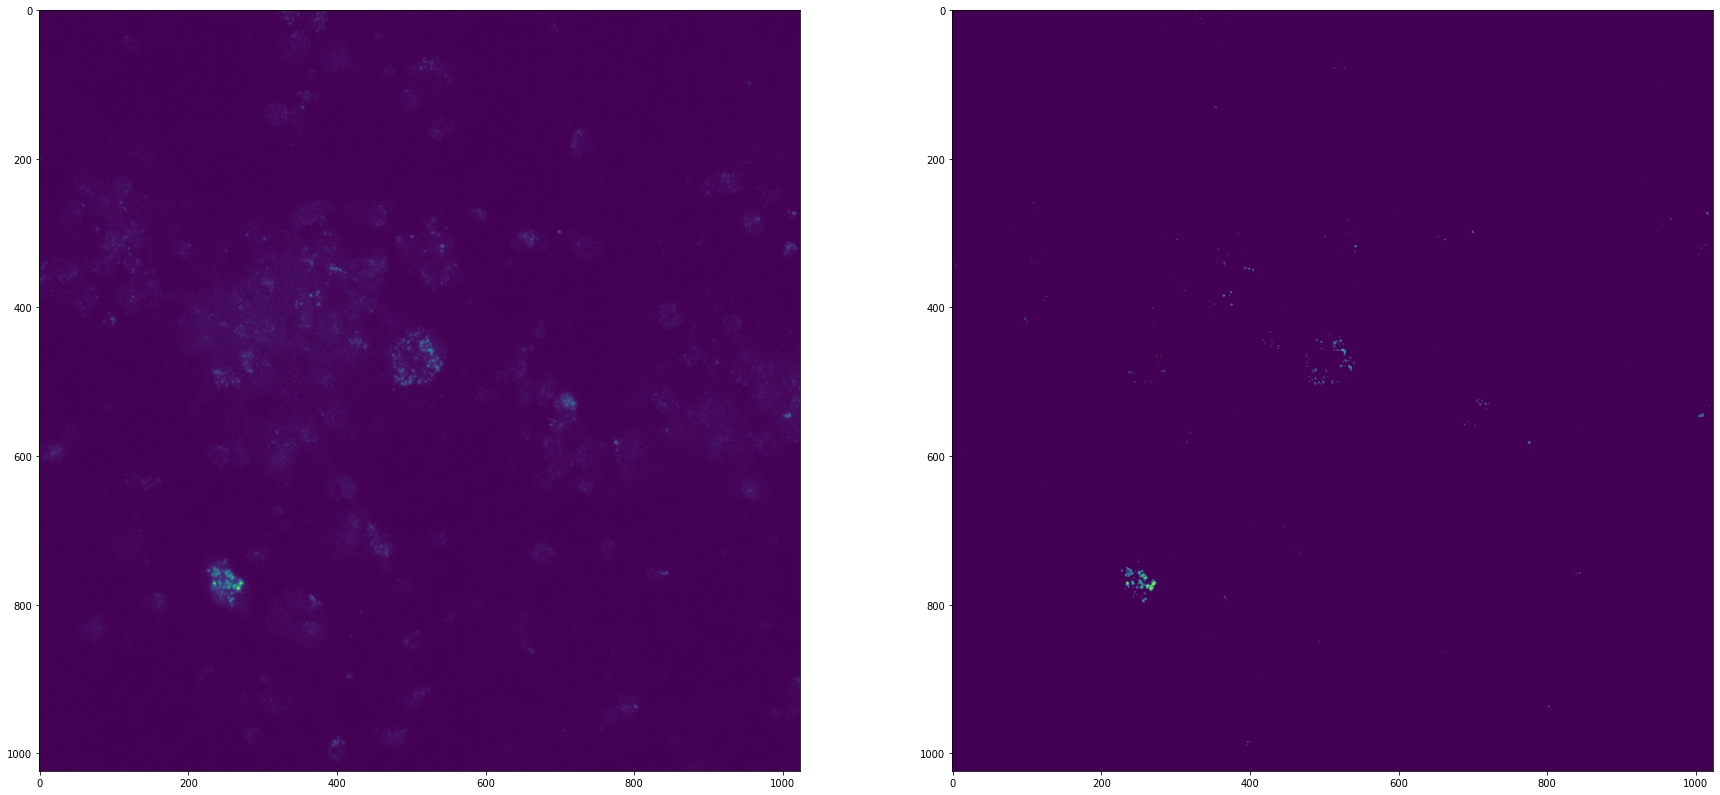

In [215]:
fig, axes = plt.subplots(1, 2, figsize=(30, 20))

axes[0].imshow(np.mean(f[:,:,:,2], axis=0))
axes[1].imshow(np.mean(f[:,:,:,2]>0.2196078431372549, axis=0))

In [102]:
# load all channels of interest subset by mask
LS = []
#PL = []
for ID in tqdm(keep_indices):
    probs_sele, masks_sele, out_float_sele, M_unique = load_im(ID, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    i = masks_sele>0
    LS.append(out_float_sele[:,:,:,2].ravel()[i])
    #PL.append(out_float_sele[:,:,:,3].ravel()[i])

l = np.hstack(LS)
#p = np.hstack(PL)

100%|██████████| 100/100 [04:26<00:00,  2.67s/it]


In [210]:
# determine thresholds
LS_thresh = np.percentile(l, 99.9)
#PLIN_thresh = np.percentile(p, 99)
thresh = [None, None, LS_thresh]#, PLIN_thresh]
print(thresh)

[None, None, 0.2196078431372549]


In [216]:
df = compute_per_cell_stats(keep_indices, zi_per_job, Nzi_per_job, probs, all_masks, all_mat, thresh, files, lines, treat, ['dapi', 'neun', 'lipidspot'])

100%|██████████| 100/100 [09:48<00:00,  5.89s/it]


In [217]:
df.to_csv(out_parent+'quant.csv')

##### 3. Plot


<Axes: xlabel='line', ylabel='lipidspot'>

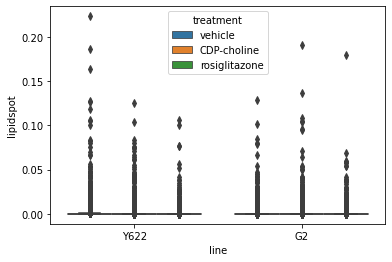

In [218]:
sns.boxplot(data=df, x='line', hue='treatment', y='lipidspot')

In [219]:
df = pd.read_csv(out_parent + 'quant.csv')
df['well'] = [x.split('_')[0] for x in df['file']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


vehicle vs. CDP-choline: t-test independent samples, P_val:3.294e-01 t=1.011e+00
vehicle vs. rosiglitazone: t-test independent samples, P_val:1.055e-02 t=2.950e+00


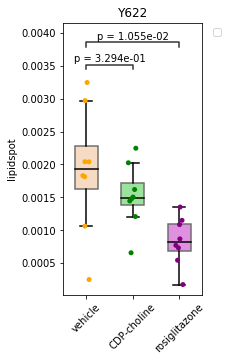

In [295]:
plt.figure(figsize=(2.5,5))

colors = dict(zip(np.unique(df['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(df['treatment']), [ 'green' , 'purple','orange']))

plot_boxplot_by_treatment('lipidspot', 'Y622', df, colors, colors2)